# Neural Quest Assignment-3
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image classification.

* We have been using MNIST by flattening 28$\times$28 images to 784-sized vectors.

* This time, we will classify images from the CIFAR-10 dataset - dimension is 32$\times$32.

* Much of this notebook remains the same as for Assignment 2, just minor changes would be needed and this assignment won't take long.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle


def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

## Load *Dataset*
Use the [pickle file](https://drive.google.com/file/d/1W4T7PdA2lJ3XLAOckKOs7lPnuDhS2Jez/view?usp=sharing) shared for this assignment here.

In [15]:
# load the data set
from google.colab import drive
drive.mount('/content/drive')
with open('/content/drive/MyDrive/soc/train_cifar.pkl', 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X']
y = dataset['y']

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


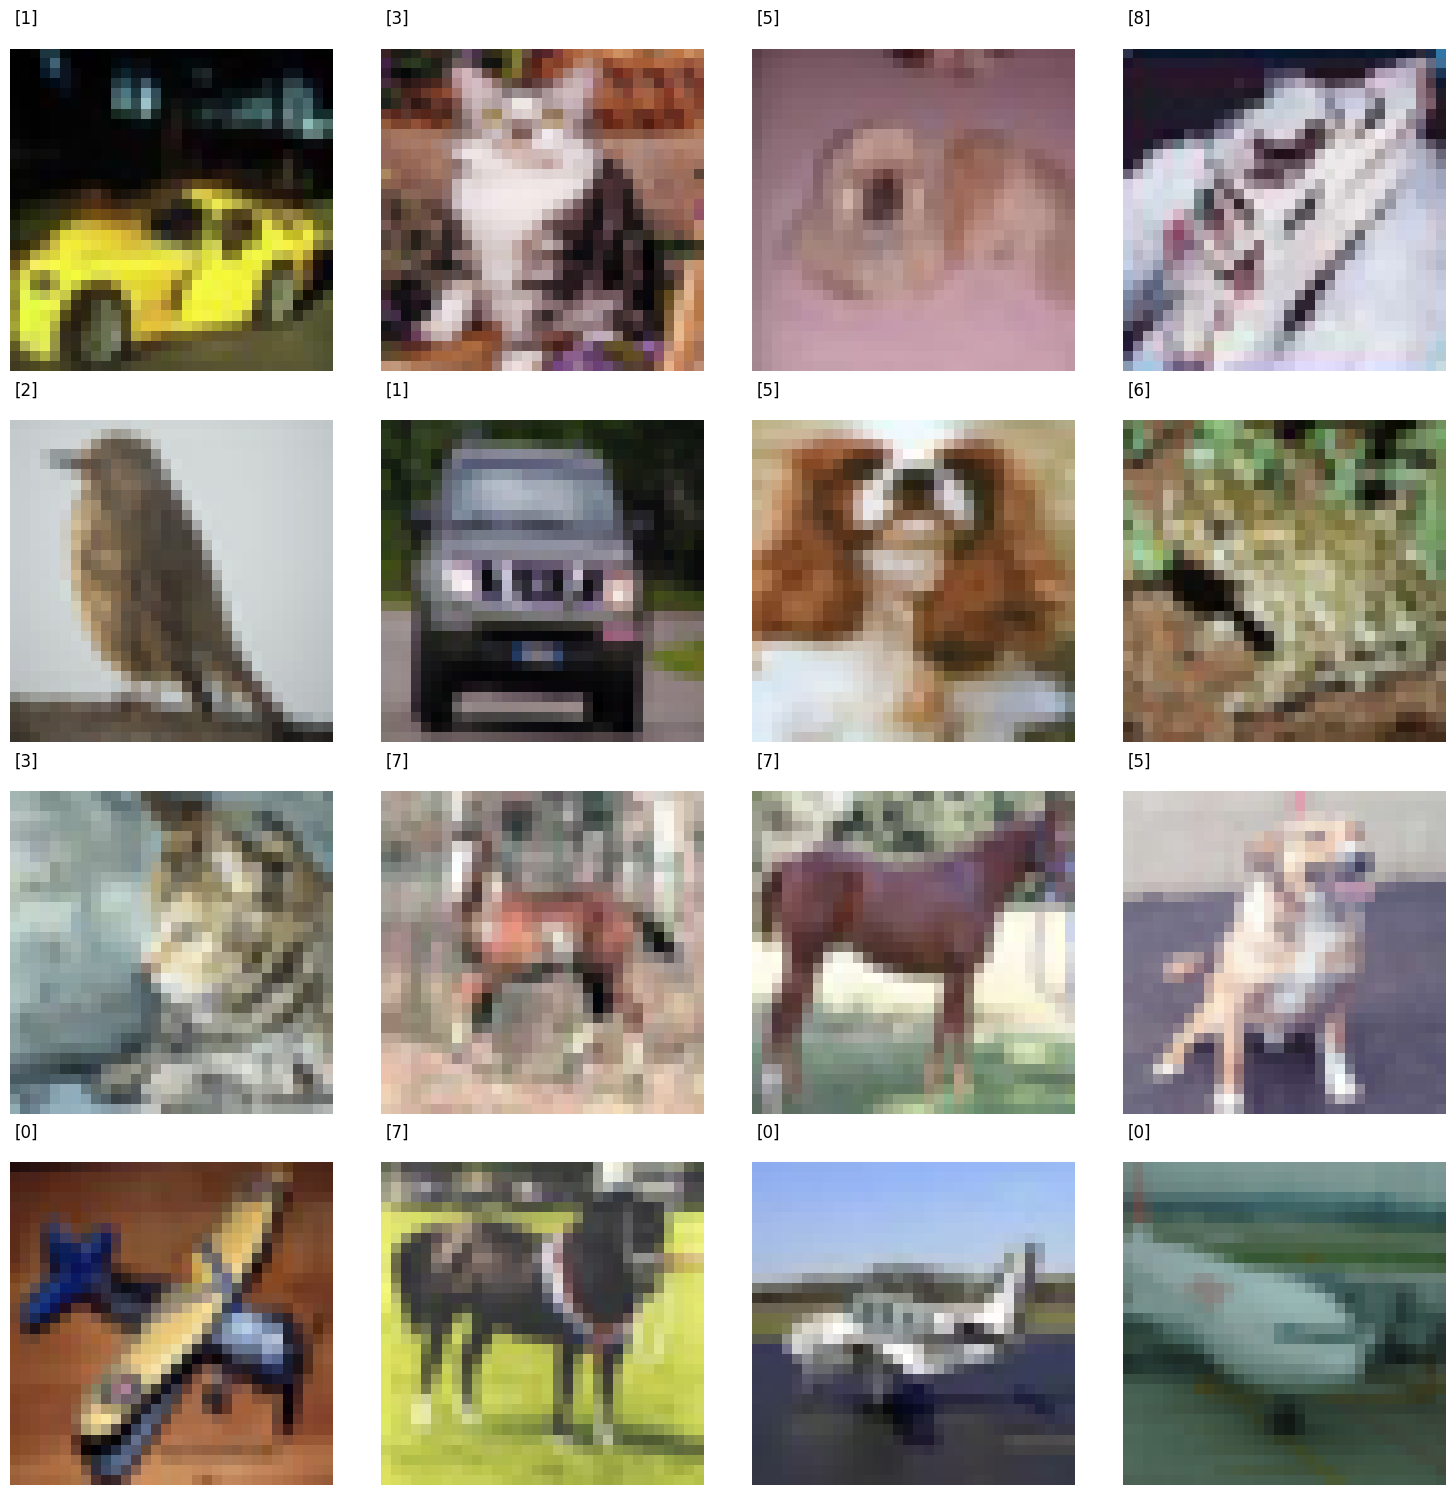

In [16]:
# display a 4x4 grid,
# choose 16 images randomly, display the images as well as corresponding labels
num_samples_to_display = 16
random_indices = np.random.choice(len(X_train), num_samples_to_display, replace=False)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
axes = axes.flatten()
for i, idx in enumerate(random_indices):
    ax = axes[i]
    images = X_train[idx]
    ax.imshow(images, cmap='gray')
    ax.text(0,-3,y_train[idx],fontsize=12)
    ax.axis('off')
plt.tight_layout()
plt.show()
X_train = np.transpose(X_train, (0,3,1,2))
X_test = np.transpose(X_test, (0,3,1,2))

## Creating a Dataset Class
In PyTorch, there is existing implementation of batch-splitting. You don't need to do it manually over here. Instead, just define a Dataset class and a Dataloader wrapping it.

A dataset class must have 3 functions - ```__init__```, ```__len__```, ```__getitem__```. Their names are pretty self-explanatory. You can read more about this [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

You will have to perform normalization, augmentation on the dataset here itself, have a look at [PyTorch Transforms](https://pytorch.org/vision/stable/transforms.html).

**Note -** While initializing the dataset class object, make sure you only pass the numpy arrays for images and labels. So the ```__init__``` function should look like
```
    def __init__(self, X, y):
```

In [17]:
# define your dataset class

class CIFARDataset(Dataset):
    def __init__(self, X, y,transform = None):
        self.x_data = torch.tensor(X, dtype=torch.float32)
        self.y_data = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return len(self.x_data)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create instances of the dataset class for train and test sets
train_data = CIFARDataset(X_train, y_train, transform=transform)
test_data = CIFARDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers beyond those you used in the second assignment and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Conv2d```](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [```nn.BatchNorm2d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)


In [18]:
# define a child class of nn.Module for your model
# specify the architecture here itself
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [19]:
def train(model, optimizer, criterion, train_loader, num_epochs, display_step=None):
    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            labels = labels.reshape(-1)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print (f'Epoch: {epoch+1}, Step: {i+1}, Loss: {loss.item():.4f}')

## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [20]:
def init_weights(model):
    for m in model.children():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [21]:
def predict(model, X_test):
  prediction = []
  with torch.no_grad():
    for i in range(X_test.shape[0]):
      if i%4 == 0:
          pred = []
          pred.append(X_test[i])
          pred.append(X_test[i+1])
          pred.append(X_test[i+2])
          pred.append(X_test[i+3])
          pred = torch.tensor(pred, dtype = torch.float32)
          output = model(pred)
          _, predicted = torch.max(output,1)
          prediction.append(predicted)
    prediction = np.array(prediction)
    prediction = prediction.reshape(-1)
    prediction1 = []
    for i in prediction:
      prediction1.append(i.numpy())
    return np.array(prediction1).reshape(-1)

In [22]:
def accuracy(prediction, labels):
  labels = labels.reshape(-1)
  n_corr = np.sum(prediction == labels)
  n_sample = labels.shape[0]
  return 100 * n_corr /n_sample

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [23]:
model = ConvNet()
init_weights(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

num_epochs = 50
train(model, optimizer, criterion, train_loader, num_epochs, display_step=100)

Epoch [1/50], Step [100/10000], Loss: 2.2972
Epoch [1/50], Step [200/10000], Loss: 2.3001
Epoch [1/50], Step [300/10000], Loss: 2.2990
Epoch [1/50], Step [400/10000], Loss: 2.3127
Epoch [1/50], Step [500/10000], Loss: 2.3126
Epoch [1/50], Step [600/10000], Loss: 2.2817
Epoch [1/50], Step [700/10000], Loss: 2.3249
Epoch [1/50], Step [800/10000], Loss: 2.2913
Epoch [1/50], Step [900/10000], Loss: 2.2825
Epoch [1/50], Step [1000/10000], Loss: 2.3225
Epoch [1/50], Step [1100/10000], Loss: 2.3163
Epoch [1/50], Step [1200/10000], Loss: 2.3074
Epoch [1/50], Step [1300/10000], Loss: 2.3103
Epoch [1/50], Step [1400/10000], Loss: 2.3029
Epoch [1/50], Step [1500/10000], Loss: 2.2978
Epoch [1/50], Step [1600/10000], Loss: 2.2867
Epoch [1/50], Step [1700/10000], Loss: 2.2997
Epoch [1/50], Step [1800/10000], Loss: 2.2984
Epoch [1/50], Step [1900/10000], Loss: 2.2919
Epoch [1/50], Step [2000/10000], Loss: 2.3034
Epoch [1/50], Step [2100/10000], Loss: 2.3058
Epoch [1/50], Step [2200/10000], Loss: 2.29

## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [25]:
pred = predict(model, X_test)
print("Accuracy: ", accuracy(pred,y_test),"%")

<ipython-input-21-d504c18224e5>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  pred = torch.tensor(pred, dtype = torch.float32)


Accuracy:  48.87 %


<ipython-input-21-d504c18224e5>:15: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  prediction = np.array(prediction)
<ipython-input-21-d504c18224e5>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prediction = np.array(prediction)


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Also create a file ```dataset.py``` with the dataset class and all necessary imports. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py```, ```dataset.py``` class files and the ```ass_2.pt``` model-weights file to the repository.

In [30]:
from google.colab import files
torch.save(model, 'ass_3.pt')
files.download('ass_3.pt') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check if it got saved right!

In [29]:
# load the model, use predict function
model1=torch.load('/content/ass_3.pt')
y_pred = predict(model1, X_test)
test_accuracy = accuracy(y_pred, y_test.reshape(-1))
print(f"Test Accuracy: {(test_accuracy):.4f}")

Test Accuracy: 48.8700


<ipython-input-21-d504c18224e5>:15: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  prediction = np.array(prediction)
<ipython-input-21-d504c18224e5>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prediction = np.array(prediction)
